In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split


In [ ]:
#pd.read_csv() loads the advertising dataset into a DataFrame.
#df.head() shows the first 5 rows so you can preview the data.

df = pd.read_csv('/content/advertising.csv')
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [ ]:
# The correlation shows how strongly each column in your dataset moves together,
#so you can spot which ones rise or fall at the same time.

df.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.901208
Radio,0.054809,1.000000,0.354104,0.349631
Newspaper,0.056648,0.354104,1.000000,0.157960
Sales,0.901208,0.349631,0.157960,1.000000


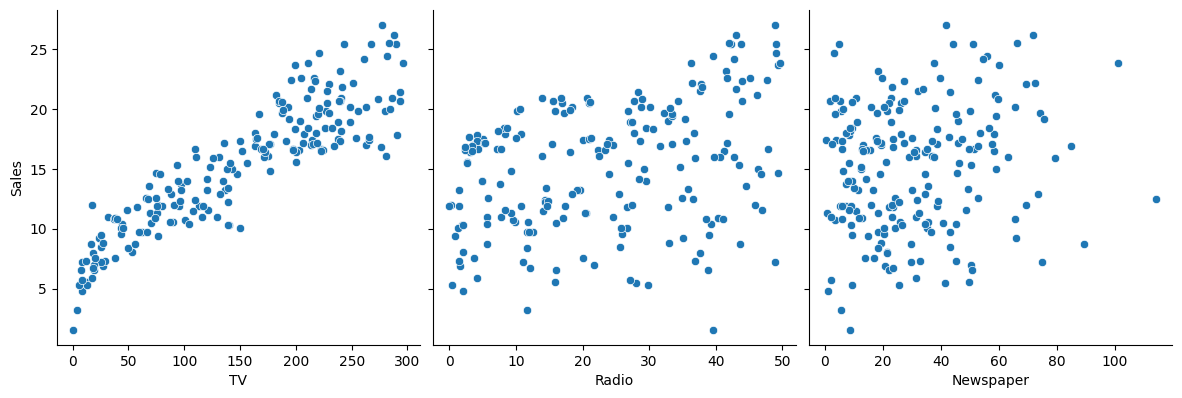

In [ ]:
# This draws little scatter plots so we can see how TV, Radio, and Newspaper ads are connected to Sales.

sns.pairplot(df, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', height=4, aspect=1, kind='scatter')
plt.show()

In [ ]:
# These tools help us split our data, test different model settings, and check how well the model performs.

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [ ]:
# Pick the columns we want to use to guess the sales
X = df[['TV','Radio','Newspaper']]

# This is the actual sales number we want to predict
y = df['Sales']


# Split the data into two parts:
# - one part to train the model (learn from)
# - one part to test the model (see how well it learned)
# test_size=0.2 means 20% goes to testing
# random_state just makes sure we get the same split every time
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# These tools help prepare our data: one makes numbers easier to compare,
# PolynomialFeatures creates extra math features so our model can learn better.

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# This creates a tool that helps make all our numbers more similar
# so the model doesn’t get confused by big and small values.
scaler = StandardScaler()

# Here, the tool learns the size of the training data
# and then scales it so everything is on the same level.
X_train_scaled = scaler.fit_transform(X_train)


# Now we use the same scaling rules on the test data
# so both training and test sets match.
X_test_scaled = scaler.transform(X_test)

In [ ]:
# These tools help us build different types of models that try to predict numbers
from sklearn.linear_model import LinearRegression,Ridge,Lasso

# These help us check how good or bad our model is at predicting
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

# These help us test our model in smarter ways to avoid overfitting
from sklearn.model_selection import GridSearchCV, cross_val_score

# This model makes predictions based on its "closest neighbors"
from sklearn.neighbors import KNeighborsRegressor

# This is another type of model that can handle complicated patterns in data
from sklearn.svm import SVR

In [ ]:
# This creates an empty box (a dictionary) where we will store our results later.
result = {}

In [ ]:
from sklearn import linear_model

# Create a Linear Regression model (this is like a math tool that tries to draw the best straight line through the data)
linear_model = LinearRegression()

# Teach the model using the training data (it learns the pattern here)
linear_model.fit(X_train_scaled,y_train)

# Ask the model to make predictions using the test data (this shows how well it learned)
y_pred_linear = linear_model.predict(X_test_scaled)

# Check how well the model did by calculating the R² score (higher score means better performance)
result['LinearRegression'] = r2_score(y_test, y_pred_linear)

# Show how far off the model was on the training data (MAE tells us the average mistake size)
print('traning MAE', mean_absolute_error(y_train, linear_model.predict(X_train_scaled)))

# Show the average mistake on the test data (good test MAE means the model works well on new data)
print('testing MAE', mean_absolute_error(y_test, y_pred_linear))

traning MAE 1.2344160869575864
testing MAE 1.2748262109549349


In [ ]:
# This creates a tool that adds extra features to our data by mixing and squaring them.
# Think of it like giving the model more “puzzle pieces” so it can see more patterns.
poly = PolynomialFeatures(degree=2)

# Here we use that tool to transform our training data into those new, richer features.
X_train_poly = poly.fit_transform(X_train_scaled)

# And here we do the same for the test data (but without learning new patterns).
X_test_poly = poly.transform(X_test_scaled)


In [ ]:
# We're teaching the computer to learn a curved (polynomial) pattern from our training data,
# then we check how well it can guess new test data, and also see how big our mistakes are.
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)

result['PolynomialRegression'] = r2_score(y_test, y_pred_poly)
print('traning MAE', mean_absolute_error(y_train, poly_reg.predict(poly.transform(X_train_scaled))))
print('testing MAE', mean_absolute_error(y_test, y_pred_poly))


traning MAE 1.0565622765313982
testing MAE 0.9033713382792137


In [ ]:
# We're trying different strengths for the Lasso model to see which one predicts best.
# GridSearchCV tests each option and picks the one that works best using 5-fold checking.

lasso = Lasso()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_cv = GridSearchCV(lasso, param_grid, cv=5)
lasso_cv.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]})

In [ ]:
# This part checks how good our Lasso model is: it makes predictions on both training and test data,
# shows the best settings it found, the importance of each feature, and how far off our guesses are on average.

y_train_pred_lasso = lasso_cv.predict(X_train_scaled)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
result['Lasso'] = r2_score(y_test, y_pred_lasso)

print('Best parameters:', lasso_cv.best_params_)
print('coefficient', lasso_cv.best_estimator_.coef_)
print('traning MAE', mean_absolute_error(y_train, y_train_pred_lasso))
print('testing MAE', mean_absolute_error(y_test, y_pred_lasso))


Best parameters: {'alpha': 0.001}
coefficient [4.58625211 1.48918938 0.08718679]
traning MAE 1.2345762846739805
testing MAE 1.2745931114207565


In [ ]:
# We're trying different settings for KNN to see which works best for our data.
# It tests different numbers of neighbors and ways to weigh them, then picks the best one.

knn = KNeighborsRegressor()
knn_param = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
knn_cv = GridSearchCV(knn, knn_param, cv=5)
knn_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']})

In [ ]:
# We are making predictions using KNN, checking how good those predictions are,
# and printing how far off we are on both the training and test data.

y_pred_knn = knn_cv.predict(X_test_scaled)
result['KNN Regressor'] = r2_score(y_test, y_pred_knn)

print('training MAE', mean_absolute_error(y_train, knn_cv.predict(X_train_scaled)))
print('test MAE', mean_absolute_error(y_test, y_pred_knn))

training MAE 0.0
test MAE 1.3075829509344288


In [ ]:
# This goes through each model and its score, then prints them nicely so we can see how well each model did.

for model_name, score in result.items():
  print(f'{model_name}: {score}')


LinearRegression: 0.9059011844150825
PolynomialRegression: 0.9533174341074796
Lasso: 0.905904568155682
KNN Regressor: 0.9169014466028194


In [ ]:
#Polynomial regression was chosen for the final prediction because it yielded the highest R-squared score,
#indicating a better fit to the data, and it also resulted in a lower Mean Absolute Error (MAE) on the test set,
#meaning its predictions were generally closer to the actual sales figures.

# This makes a small table to compare the real sales vs the sales our model guessed
prediction = pd.DataFrame({"Actual Sales": y_test, "Predicted Sales": y_pred_poly})
prediction.head()

,Actual Sales,Predicted Sales
95,16.9,17.562438
15,22.4,21.962857
30,21.4,22.075805
158,7.3,7.349163
128,24.7,23.236844


In [ ]:
# This calculates the difference between what we actually sold and what our model predicted

residual = prediction['Actual Sales'] - prediction['Predicted Sales']
residual.head(10)

,0
95,-0.662438
15,0.437143
30,-0.675805
158,-0.049163
128,1.463156
115,0.228905
69,0.171275
170,-0.369049
174,-0.514926
45,-0.814806


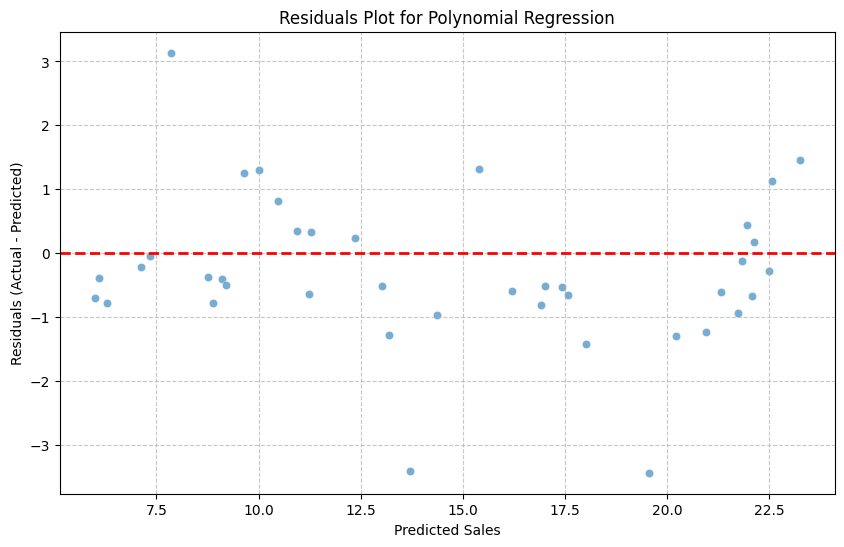

In [ ]:
# This plot helps us see how far off our predictions are from the real sales.
# Each dot shows the difference between what the model guessed and the actual value.
# The red line at 0 means a perfect guess. Dots above or below show errors.

plt.figure(figsize=(10, 6))
sns.scatterplot(x = y_pred_poly, y = residual, alpha=0.6)
plt.axhline(y = 0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot for Polynomial Regression')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

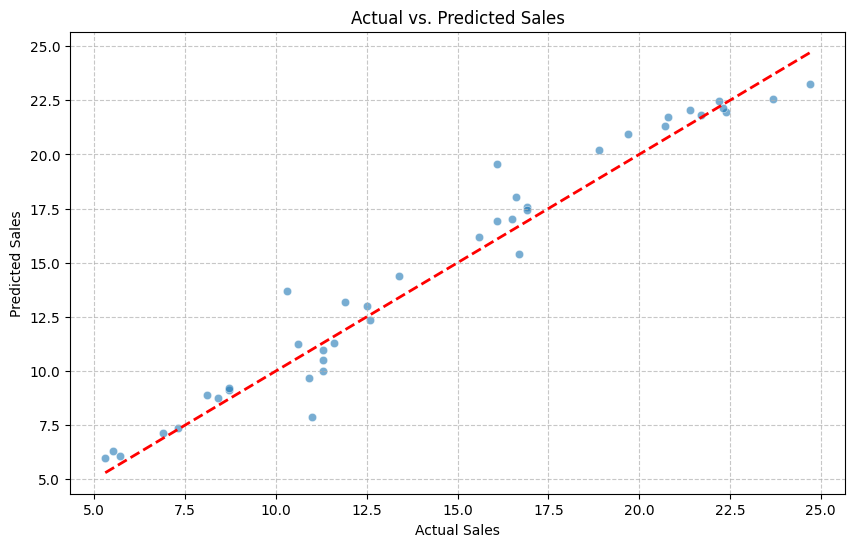

In [ ]:

# This makes a chart that shows how close our predictions are to the real sales.
# The dots are predictions, and the red dashed line is where perfect predictions would be.
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_poly, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs. Predicted Sales')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()